<a href="https://colab.research.google.com/github/younghun-cha/Healthcare-Big-Data-Engineer/blob/main/AI/04-Deep_Learning_CNNs/01_Deep_Learning_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch: Deep Learning 기본

## 1. Linear Regression: 선형 회귀

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../dataset/tv-advertising.csv')
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


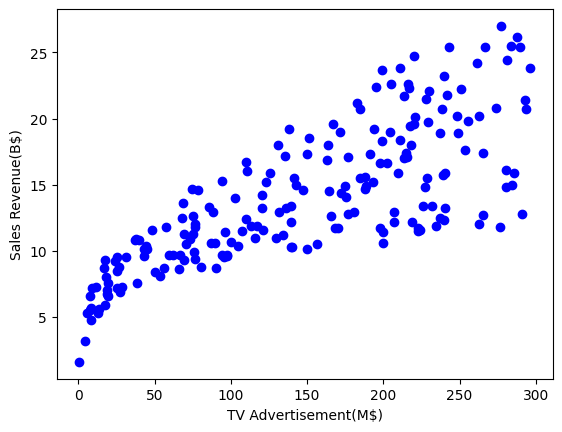

In [5]:
# TV 광고비용별 매출 시각화
import matplotlib.pyplot as plt

plt.plot(df.TV, df.Sales,'bo')
plt.xlabel('TV Advertisement(M$)')
plt.ylabel('Sales Revenue(B$)')

plt.show()

a: 0.047536639810454806 b: 7.032593648780168


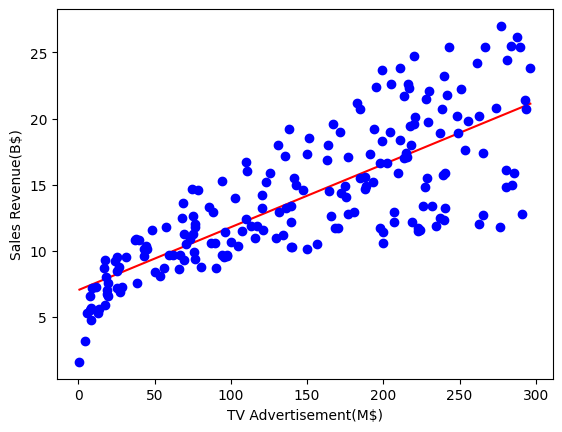

In [6]:
# 4.3 최소제곱법으로 회귀선 구하기
import numpy as np
import matplotlib.pyplot as plt

X = df.TV.values.astype(np.float32)
Y = df.Sales.values.astype(np.float32)

# X, Y의 평균을 구합니다.
x_bar = sum(X) / len(X)
y_bar = sum(Y) / len(Y)

# 최소제곱법으로 a, b를 구합니다.
a = sum([(y - y_bar) * (x - x_bar) for y, x in list(zip(Y, X))])
a /= sum([(x - x_bar) ** 2 for x in X])
b = y_bar - a * x_bar
print('a:', a, 'b:', b)

# 그래프를 그리기 위해 회귀선의 x, y 데이터를 구합니다.
line_x = np.arange(min(X), max(X), 0.01)
line_y = a * line_x + b

# 붉은색 실선으로 회귀선을 그립니다.
plt.plot(line_x,line_y,'r-')

plt.plot(X,Y,'bo')
plt.xlabel('TV Advertisement(M$)')
plt.ylabel('Sales Revenue(B$)')
plt.show()

## 2. PyTorch Linear Regression

### 2-1. DataLoader 구축

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.7 , 
                                                    random_state=100)
X_train.shape, X_test.shape

((140,), (60,))

In [8]:
from torch.utils.data import TensorDataset, DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True)

### 2-2. Loss, Weight, Bias

In [9]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad=True)
 
def loss_fn(input, target):
    return (input-target).pow(2).mean()

def model(xb):
    return xb @ weight + bias

### 2-3. no_grad() 학습

In [10]:
learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()

        with torch.no_grad():
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate
            weight.grad.zero_()
            bias.grad.zero_()
 
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 39.9149
Epoch 10  Loss 6.5228
Epoch 20  Loss 0.0080
Epoch 30  Loss 65.6664
Epoch 40  Loss 0.0376
Epoch 50  Loss 1.3861
Epoch 60  Loss 15.9411
Epoch 70  Loss 0.3749
Epoch 80  Loss 0.0178
Epoch 90  Loss 15.6691
Epoch 100  Loss 15.9481
Epoch 110  Loss 1.2977
Epoch 120  Loss 0.3684
Epoch 130  Loss 0.9329
Epoch 140  Loss 2.2843
Epoch 150  Loss 24.7824
Epoch 160  Loss 32.1975
Epoch 170  Loss 13.9011
Epoch 180  Loss 4.3724
Epoch 190  Loss 0.6546


### 2-4. Prediction

In [11]:
print('Final Parameters:', weight.item(), bias.item())

X_test = X_test.reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()

Final Parameters: 4.301880359649658 13.854516983032227


### 2-5. Visualization

In [12]:
def linear_plot():
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(X_train_norm, y_train, 'o', markersize=3)
    plt.plot(X_test_norm, y_pred, '--', lw=2)
    plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
    ax.set_xlabel('x', size=15)
    ax.set_ylabel('y', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

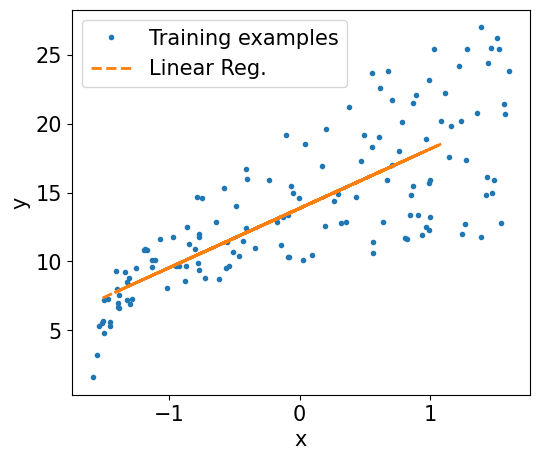

In [13]:
linear_plot()

### 2-2. Train: torch.nn & torch.optim (Optimizer)

In [14]:
import torch.nn as nn

input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)

loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch)[0]

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0  Loss 70.3850
Epoch 10  Loss 2.3432
Epoch 20  Loss 0.9598
Epoch 30  Loss 1.9510
Epoch 40  Loss 36.9903
Epoch 50  Loss 8.2809
Epoch 60  Loss 0.0059
Epoch 70  Loss 50.7231
Epoch 80  Loss 14.0436
Epoch 90  Loss 29.5912
Epoch 100  Loss 0.3802
Epoch 110  Loss 34.7300
Epoch 120  Loss 34.2160
Epoch 130  Loss 5.0460
Epoch 140  Loss 34.4347
Epoch 150  Loss 4.4566
Epoch 160  Loss 4.6622
Epoch 170  Loss 1.6094
Epoch 180  Loss 5.3504
Epoch 190  Loss 0.9156


In [15]:
print('Final Parameters:', weight.item(), bias.item())

X_test = X_test.reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()

Final Parameters: 4.301880359649658 13.854516983032227


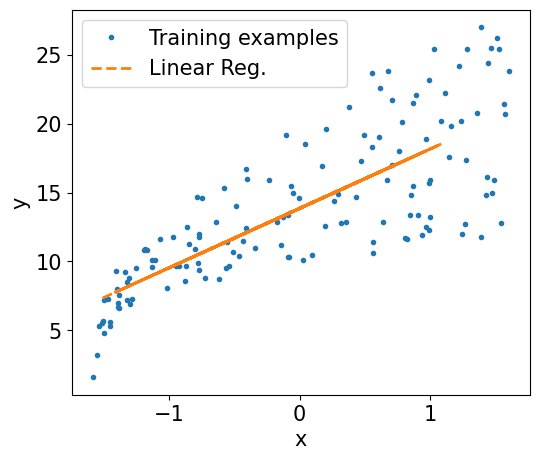

In [16]:
linear_plot()

## 3. Activation Function: 활성화 함수

### 3-1. Logistic Function

In [17]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print(f'P(y=1|x) = {logistic_activation(X, w):.3f}') 

P(y=1|x) = 0.888


In [18]:
# W : shape = (n_output_units, n_hidden_units+1)

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : shape = (n_hidden_units + 1, n_samples)
A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)

print('Net Input: \n', Z)
print('Output Units:\n', y_probas) 

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [19]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label:', y_class) 

Predicted class label: 0


### 3-2. Softmax Function

In [20]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [21]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

### 3-3. Hyperbolic Tangent

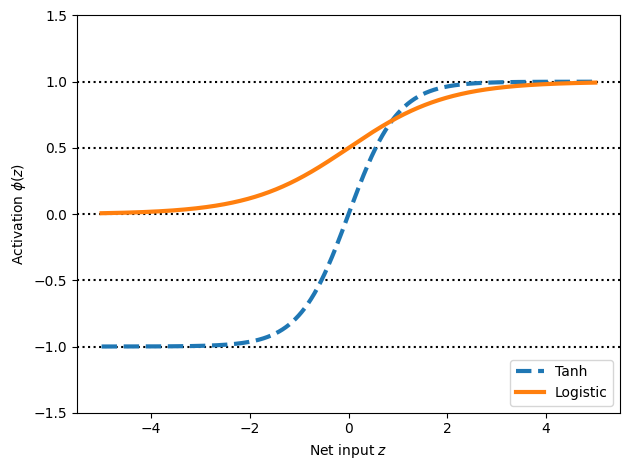

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

### 3-4. ReLU(Rectified linear unit activation)

In [23]:
torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)

## 4. Pytorch: Classification - Spaceship Titanic

In [24]:
titanic = pd.read_csv('../dataset/spaceship-preprocessing.csv')
titanic.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1


### 4-1. Dataset Load

In [25]:
X = titanic.drop('Transported', axis=1).values.astype(np.float32)
y = titanic['Transported'].values
 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1./3, random_state=1)
X_train.shape, X_test.shape

((5795, 10), (2898, 10))

In [26]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

### 4-2. Model Build

In [27]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 2
         
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 4-3. Train

In [28]:
num_epochs = 20
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    
    print("Epoch %d Train: Loss: %.4f Acc: %.4f" %
          (epoch,
           loss_hist[epoch], 
           accuracy_hist[epoch]))
      

Epoch 0 Train: Loss: 0.6245 Acc: 0.7041
Epoch 1 Train: Loss: 0.5537 Acc: 0.7736
Epoch 2 Train: Loss: 0.5375 Acc: 0.7774
Epoch 3 Train: Loss: 0.5322 Acc: 0.7798
Epoch 4 Train: Loss: 0.5292 Acc: 0.7831
Epoch 5 Train: Loss: 0.5272 Acc: 0.7853
Epoch 6 Train: Loss: 0.5255 Acc: 0.7858
Epoch 7 Train: Loss: 0.5244 Acc: 0.7884
Epoch 8 Train: Loss: 0.5234 Acc: 0.7877
Epoch 9 Train: Loss: 0.5226 Acc: 0.7881
Epoch 10 Train: Loss: 0.5218 Acc: 0.7876
Epoch 11 Train: Loss: 0.5212 Acc: 0.7883
Epoch 12 Train: Loss: 0.5201 Acc: 0.7905
Epoch 13 Train: Loss: 0.5196 Acc: 0.7910
Epoch 14 Train: Loss: 0.5190 Acc: 0.7915
Epoch 15 Train: Loss: 0.5183 Acc: 0.7924
Epoch 16 Train: Loss: 0.5178 Acc: 0.7921
Epoch 17 Train: Loss: 0.5173 Acc: 0.7940
Epoch 18 Train: Loss: 0.5168 Acc: 0.7941
Epoch 19 Train: Loss: 0.5165 Acc: 0.7936


### 4-4. Loss, Accuracy

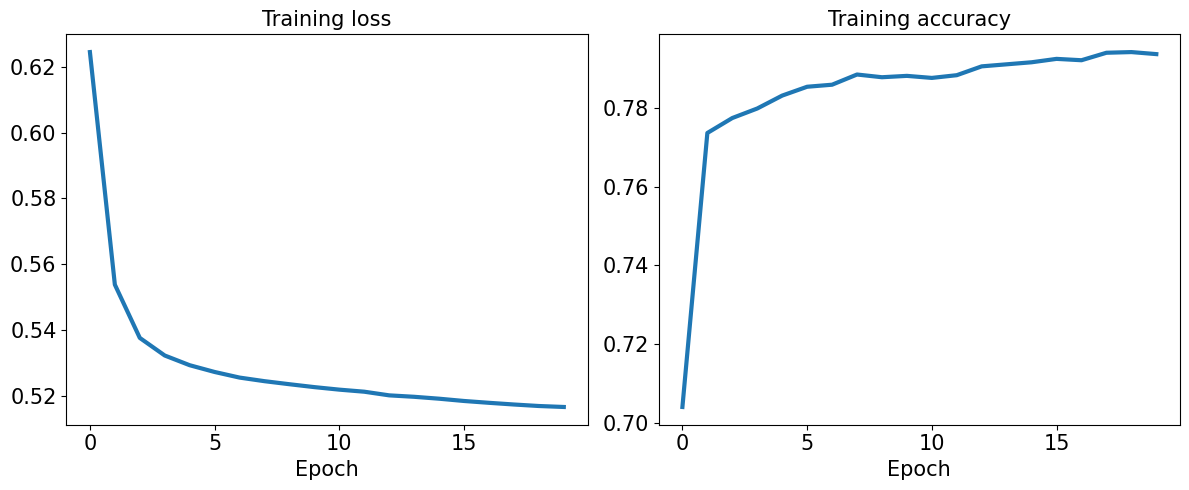

In [29]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
 
plt.show()

### 4-5. Evaluating

In [30]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.7933


### 4-6. Save & Load Model
- torch.save( )
- torch.save(model.state_dict( ))

In [31]:
path = 'spaceship-tiatnic.pt'
torch.save(model, path)

In [32]:
model_new = torch.load(path)
model_new.eval()

Model(
  (layer1): Linear(in_features=10, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=2, bias=True)
)

In [33]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.7933


In [34]:
path = 'spaceship-tiatnic_state.pt'
torch.save(model.state_dict(), path)

In [35]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>